#Installation of the dataset

In [1]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00


#Import necessary libraries and packages

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random

import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer,BatchNormalization,Dropout,Input,LayerNormalization
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam

from google.colab import drive
from google.colab import files

from datasets import load_dataset

from transformers import(BertTokenizerFast, TFBertTokenizer, BertTokenizer,RobertaTokenizerFast,
                         DataCollatorWithPadding, TFRobertaForSequenceClassification, TFBertForSequenceClassification,
                         TFBertModel, create_optimizer)

In [3]:
BATCH_SIZE=8

#Data Preparation for Bert Model

In [4]:
dataset_id='imdb'
dataset = load_dataset(dataset_id)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating unsupervised split: 0 examples [00:00, ? examples/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [6]:
dataset['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [7]:
dataset['train'][90]

{'text': 'Devil Hunter gained notoriety for the fact that it\'s on the DPP \'Video Nasty\' list, but it really needn\'t have been. Many films on the list where there for God (and DPP) only known reasons, and while this isn\'t the tamest of the bunch; there isn\'t a lot here that warrants banning...which is a shame because I never would have sat through it where it not for the fact that it\'s on \'the shopping list\'. The plot actually gives the film a decent base - or at least more of a decent base than most cannibal films - and it follows an actress who is kidnapped and dragged off into the Amazon jungle. A hunter is then hired to find her, but along the way he has to brave the natives, lead by a man who calls himself "The Devil" (hence the title). The film basically just plods along for eighty five minutes and there really aren\'t many scenes of interest. It\'s a real shame that Jess Franco ended up making films like this because the man clearly has talent; as seen by films such as T

#Building Bert Model

In [8]:
model_id="bert-base-uncased"
tokenizer=BertTokenizerFast.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [10]:
tokenizer.is_fast

True

In [11]:
test_input_1='The weather of today is Great! zwp'
test_input_2='How are you doing?'
inputs=[test_input_1,test_input_2]

tokenizer.tokenize(inputs)

['the',
 'weather',
 'of',
 'today',
 'is',
 'great',
 '!',
 'z',
 '##w',
 '##p',
 'how',
 'are',
 'you',
 'doing',
 '?']

In [12]:
input_3 = "I love my life, i am rich"
tokenizer.tokenize(input_3)

['i', 'love', 'my', 'life', ',', 'i', 'am', 'rich']

In [13]:
output=tokenizer(inputs, padding=True, truncation=True, max_length=128)
print(output)

{'input_ids': [[101, 1996, 4633, 1997, 2651, 2003, 2307, 999, 1062, 2860, 2361, 102], [101, 2129, 2024, 2017, 2725, 1029, 102, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]}


In [14]:
tokenizer.decode(output['input_ids'][0])

'[CLS] the weather of today is great! zwp [SEP]'

In [15]:
tokenizer.decode(output['input_ids'][1])

'[CLS] how are you doing? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [16]:
def preprocess_function(examples):
  return tokenizer(examples["text"], padding=True, truncation=True,)

In [17]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [18]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [19]:
tf_train_dataset = tokenized_dataset['train'].to_tf_dataset(
    columns =['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE
)

In [20]:
tf_val_dataset = tokenized_dataset['test'].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE
)

In [21]:
def swap_positions(dataset):
  return {'input_ids':dataset['input_ids'],
          'token_type_ids': dataset['token_type_ids'],
          'attention_mask': dataset['attention_mask'],}, dataset['label']

In [22]:
tf_train_dataset = tf_train_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)
tf_val_dataset = tf_val_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)

In [23]:
for i in tf_train_dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[  101,  1000, 18082, ...,     0,     0,     0],
       [  101,  2167,  3088, ...,     0,     0,     0],
       [  101,  2129,  2038, ...,     0,     0,     0],
       ...,
       [  101,  2703,  2310, ...,     0,     0,     0],
       [  101,  3883,  7920, ...,     0,     0,     0],
       [  101,  3631,  7698, ...,     0,     0,     0]])>, 'token_type_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}, <tf.Tensor: shape=(8,), dtype=int64, nu

In [24]:
tf_val_dataset

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

#Data preparation for Roberta Model

In [25]:
model_id = "roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(model_id)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [26]:
def preprocess_function(examples):
  return tokenizer(examples["text"],padding=True,truncation=True,)

In [27]:
tokenized_dataset = dataset.map(preprocess_function,)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [28]:
tokenized_dataset['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [29]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [30]:
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['input_ids','attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
)

In [31]:
tf_val_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids','attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
)

In [32]:
def swap_positions(dataset):
  return {'input_ids':dataset['input_ids'],
          'attention_mask':dataset['attention_mask'],},dataset['label']

In [33]:
tf_train_dataset=tf_train_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)
tf_val_dataset=tf_val_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)

In [34]:
for i in tf_train_dataset.take(1):
  print(i)

InvalidArgumentError: ignored

#Data Preparation for XtremeDistill Model

In [36]:
model_id="microsoft/xtremedistil-l6-h256-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_id)

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/525 [00:00<?, ?B/s]

In [37]:
tokenizer.is_fast

True

In [38]:
def preprocess_function(examples):
  return tokenizer(examples["text"],max_length=512,padding=True,truncation=True,)

In [39]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [40]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [41]:
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
)

In [42]:
tf_val_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
)

In [43]:
def swap_positions(dataset):
  return {'input_ids':dataset['input_ids'],
          'token_type_ids':dataset['token_type_ids'],
          'attention_mask':dataset['attention_mask'],},dataset['label']

In [44]:
tf_train_dataset=tf_train_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)
tf_val_dataset=tf_val_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)

In [45]:
for i in tf_val_dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[  101,  1045,  2428, ...,     0,     0,     0],
       [  101,  1012,  1012, ...,     0,     0,     0],
       [  101,  2023,  2143, ...,     0,     0,     0],
       ...,
       [  101,  2006, 14414, ...,     0,     0,     0],
       [  101,  2009,  1005, ...,     0,     0,     0],
       [  101,  1045,  2428, ...,     0,     0,     0]])>, 'token_type_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}, <tf.Tensor: shape=(8,), dtype=int64, nu

In [46]:
tf_val_dataset

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# **Model Building**

#Modeling with TFBertForSequenceClassification

In [47]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#Modeling with XtremeDistillForSequenceClassification

In [48]:
model_xt=TFBertForSequenceClassification.from_pretrained(model_id,num_labels=2)
model_xt.summary()

tf_model.h5:   0%|          | 0.00/51.1M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at microsoft/xtremedistil-l6-h256-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  12750080  
                                                                 
 dropout_57 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  514       
                                                                 
Total params: 12750594 (48.64 MB)
Trainable params: 12750594 (48.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#Modeling with TFBertModel

In [49]:
model_tfbert = TFBertModel.from_pretrained("bert-base-uncased")
model_tfbert.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
input_ids=Input(shape=(512,), dtype=tf.int64, name='input_ids')
token_type_ids = Input(shape=(512,), dtype=tf.int64, name='token_type_ids')
attention_mask = Input(shape=(512,), dtype=tf.int64, name='attention_mask')

x = model_tfbert([input_ids, token_type_ids, attention_mask])
print(x)
x=Dense(128, activation='relu')(x[0][:, 0,:])
output=Dense(1, activation='sigmoid', name='label')(x)

custom_bert = tf.keras.Model(inputs=[input_ids,token_type_ids,attention_mask], outputs=output)


TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<KerasTensor: shape=(None, 512, 768) dtype=float32 (created by layer 'tf_bert_model')>, pooler_output=<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf_bert_model')>, past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)


In [51]:
custom_bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                              

#Modeling with TFRobertaForSequenceClassification

In [52]:
model_tfrob = TFRobertaForSequenceClassification.from_pretrained(model_id, num_labels=2)
model_tfrob.summary()

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at microsoft/xtremedistil-l6-h256-uncased were not used when initializing TFRobertaForSequenceClassification: ['bert']
- This IS expected if you are initializing TFRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/xtremedistil-l6-h256-uncased and are newly initialized: ['roberta', 'classifie

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  12684288  
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  66306     
 ificationHead)                                                  
                                                                 
Total params: 12750594 (48.64 MB)
Trainable params: 12750594 (48.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **Model Training**

In [57]:
num_epochs = 3
batches_per_epoch = len(tokenized_dataset["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

In [58]:
optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps)

In [59]:
model_xt.compile(loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy'],)


In [60]:
history=model_xt.fit(
    tf_train_dataset.take(1000),
    validation_data=tf_val_dataset,
    epochs=3,)

Epoch 1/3
1000/1000 [==============================] - 428s 404ms/step - loss: 0.5289 - accuracy: 0.3952 - val_loss: 0.3103 - val_accuracy: 0.8507
Epoch 2/3
1000/1000 [==============================] - 360s 360ms/step - loss: 0.3229 - accuracy: 0.4897 - val_loss: 0.2823 - val_accuracy: 0.8445
Epoch 3/3
1000/1000 [==============================] - 331s 331ms/step - loss: 0.3689 - accuracy: 0.3705 - val_loss: 0.3388 - val_accuracy: 0.1254


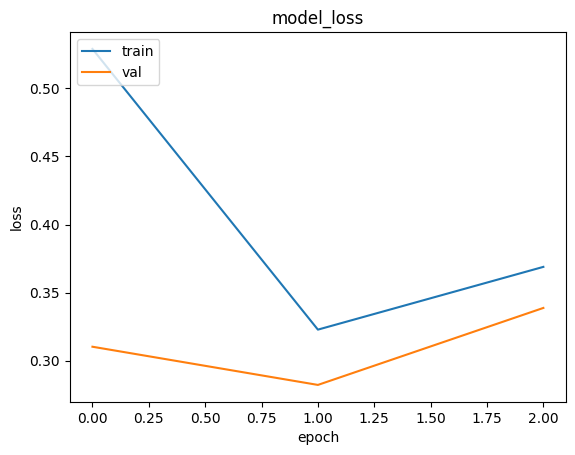

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

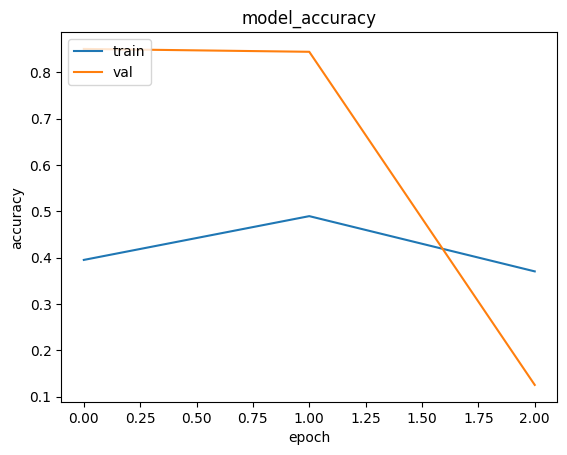

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **Model Testing**

In [63]:
inputs = tokenizer(["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! ",
                    "very good start, but movie started becoming uninteresting at some point though initially i thought it would have been much more fun. There was too much background noise, but later on towards the middle of the movie, my favorite character got in and he did a great job, so over "], padding=True,return_tensors="tf")

logits = model(**inputs).logits
print(logits)

tf.Tensor(
[[-0.30843443]
 [-0.18744667]], shape=(2, 1), dtype=float32)


# **Conversion to onnx format**

#Installation

In [64]:
!pip install -U tf2onnx
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.9 MB/s eta 0:00:00


In [65]:
import onnxruntime as rt
import tf2onnx
rt.get_device()

'CPU'

#From Keras Model

In [66]:
output_path = "/content/drive/MyDrive/ML-with-tensorflow/xtremedistill.onnx"

In [67]:
spec = [tf.TensorSpec((None,512),tf.int64, name="input_ids"),
        tf.TensorSpec((None,512),tf.int64, name="token_type_ids"),
        tf.TensorSpec((None,512),tf.int64, name="attention_mask")]

model_proto, _ = tf2onnx.convert.from_keras(
    model, input_signature=spec,
    opset=17, output_path=output_path,)
output_names = [n.name for n in model_proto.graph.output]

In [68]:
print(output_names)

['logits']


#Inference

#Benchmarking Onnx

In [69]:
text=["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes!"]

# text = ["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! ",
#                     "very good start, but movie started becoming uninteresting at some point though initially i thought it would have been much more fun. There was too much background noise, but later on towards the middle of the movie, my favorite character got in and he did a great job, so over ",
#                     "very good start, but movie started becoming uninteresting at some point though initially i thought it would have been much more fun. There was too much background noise, but later on towards the middle of the movie, my favorite character got in and he did a great job, so overall i will give this movie a pass "]


inputs = tokenizer(text,padding='max_length',max_length=512,truncation=True,return_tensors="np")

N_PREDICTIONS = 1
print(inputs)

{'input_ids': array([[  101,  2023,  3185,  3504,  2200,  5875,  1010,  1045,  2293,
         1996,  2755,  2008,  1996,  5889,  2079,  1037,  2307,  3105,
         1999,  4760,  2129,  2111,  2973,  1999,  1996,  4985,  2301,
         1010,  2029,  2347,  1005,  1056,  2200,  2204,  2012,  2035,
         1012,  2021,  2012, 19738,  3367,  2023,  3185, 28667, 29313,
         2015,  2023,  5019,   999,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,

In [70]:
providers=['CPUExecutionProvider']
m = rt.InferenceSession(output_path, providers=providers)

t1 = time.time()
for _ in range(N_PREDICTIONS):
  onnx_pred = m.run(["logits"], {'input_ids':inputs['input_ids'],
                                'token_type_ids':inputs['token_type_ids'],
                                'attention_mask':inputs['attention_mask']})
print("Time for a single Prediction", (time.time() - t1)/N_PREDICTIONS)

Time for a single Prediction 1.3750715255737305


In [71]:
print(onnx_pred)

[array([[-0.30843452]], dtype=float32)]


#Benchmarking TF

In [72]:
t1 = time.time()
for _ in range(N_PREDICTIONS):
  logits = model(**inputs).logits
print(logits)
print("Time for a single Prediction", (time.time() - t1)/N_PREDICTIONS)

tf.Tensor([[-0.30843437]], shape=(1, 1), dtype=float32)
Time for a single Prediction 0.2514336109161377


In [74]:
tf, cpu = 600ms
tf, gpu = 130ms
tf_size = 50MB

onnx, cpu = 400ms
onnx, gpu = 8ms
onnx_size = 50MB
onnx_acc  = 91.9%

onnx_quantized, cpu = 190ms
onnx_quantized, gpu = 140ms
onnx_quantized_size = 13MB
onnx_quantized_acc  = 89.7%

SyntaxError: ignored

#Quantization with Onnx

In [75]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

In [76]:
model_fp32 = '/content/drive/MyDrive/ML-with-tensorflow/xtremedistill.onnx'
model_quant = '/content/drive/MyDrive/ML-with-tensorflow/xtremedistill_quantized.onnx'

In [77]:
quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type = QuantType.QUInt8)

Ignore MatMul due to non constant B: /[tf_bert_for_sequence_classification/bert/encoder/layer_._0/attention/self/MatMul]
Ignore MatMul due to non constant B: /[tf_bert_for_sequence_classification/bert/encoder/layer_._0/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[tf_bert_for_sequence_classification/bert/encoder/layer_._1/attention/self/MatMul]
Ignore MatMul due to non constant B: /[tf_bert_for_sequence_classification/bert/encoder/layer_._1/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[tf_bert_for_sequence_classification/bert/encoder/layer_._2/attention/self/MatMul]
Ignore MatMul due to non constant B: /[tf_bert_for_sequence_classification/bert/encoder/layer_._2/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[tf_bert_for_sequence_classification/bert/encoder/layer_._3/attention/self/MatMul]
Ignore MatMul due to non constant B: /[tf_bert_for_sequence_classification/bert/encoder/layer_._3/attention/self/MatMul_1]
Ignore MatMul due to non

#Accuracy Drop due to Quantization

In [78]:
unbatched_val_dataset=tf_val_dataset.unbatch()

In [79]:
N_SAMPLES=1024

In [80]:
def accuracy(model):
  total=0
  for text,label in unbatched_val_dataset.take(N_SAMPLES):

    onnx_pred = model.run(["logits"], {'input_ids':[text['input_ids'].numpy()],
                                'token_type_ids':[text['token_type_ids'].numpy()],
                                'attention_mask':[text['attention_mask'].numpy()]})
    if np.argmax(onnx_pred, axis = -1)[0][0] == label.numpy():
      total+=1
  return (total/N_SAMPLES)*100

In [ ]:
providers=['CPUExecutionProvider']
m = rt.InferenceSession(model_fp32, providers=providers)
m_q = rt.InferenceSession(model_quant, providers=providers)
print(accuracy(m_q))
print(accuracy(m))

#Understanding Temperature in Distillation

In [ ]:
import numpy as np

In [ ]:
def softmax(logits,T):
  denominator=np.sum([np.exp(i/T) for i in logits])
  return [np.exp(i/T)/denominator for i in logits]

In [ ]:
logits=[10,13,17,5]

In [ ]:
print("For T=1 ------>",softmax(logits,1))
print("For T=2 ------>",softmax(logits,2))
print("For T=3 ------>",softmax(logits,3))
print("For T=5 ------>",softmax(logits,5))
print("For T=10 ----->",softmax(logits,10))
print("For T=10000 -->",softmax(logits,10000))